### Notebook to show the EDES parameters fitted on the MIR LIR and healthy OGTTs

In [2]:
using CairoMakie
using CSV 
using RData
using DataFrames

In [ ]:
file_path_healthy = "C:/Users/20192809/Documents/GitHub/EDES/MIRLIR_pipeline/Metadata/Training_healthy_EDES_fits.csv"
file_path_MIR = "C:/Users/20192809/Documents/GitHub/EDES/MIRLIR_pipeline/Metadata/Training_MIR_EDES_fits.csv"
file_path_LIR = "C:/Users/20192809/Documents/GitHub/EDES/MIRLIR_pipeline/Metadata/Training_LIR_EDES_fits.csv"

data_healthy = CSV.read(file_path_healthy, DataFrame)
data_MIR = CSV.read(file_path_MIR, DataFrame)
data_LIR = CSV.read(file_path_LIR, DataFrame);

file_path = "C:/Users/20192809/OneDrive - TU Eindhoven/TUe/Thesis/R shenanigans/MIRLIR/MIRLIR_parameters.RData"

flexmix_parameters = RData.load(file_path)



5×3 Matrix{Float64}:
 0.577626      0.859955     0.849834
 0.052023      0.0042758    0.00975063
 0.000278308  -0.00016494  -0.00041157
 0.0220431     0.00936498   0.0
 0.0584429     0.0549397    0.0637257

In [4]:
# Add a new column with labels
data_healthy.state .= 2
data_MIR.state .= 1
data_LIR.state .= 0

# Combine data in blocks of 6 rows and adjust IDs
block_size = 6

# Interleave the rows for the training set, grouping 6 rows from each and assigning same ID for each block
training_set = DataFrame()
id_counter = 1  # Initialize ID counter
for i in 1:block_size:nrow(data_LIR)
    # For each block of 6 rows
    block_LIR = data_LIR[i:i+block_size-1, :]
    block_MIR = data_MIR[i:i+block_size-1, :]
    block_healthy = data_healthy[i:i+block_size-1, :]
    
    # Assign the same ID for all rows within the block
    block_LIR.Patient_ID .= id_counter
    block_MIR.Patient_ID .= id_counter+1
    block_healthy.Patient_ID .= id_counter+2
    
    # Update the ID counter (move to the next ID for the next block)
    id_counter += 3
    
    # Append to the final interleaved DataFrame
    append!(training_set, block_LIR)
    append!(training_set, block_MIR)
    append!(training_set, block_healthy)
end

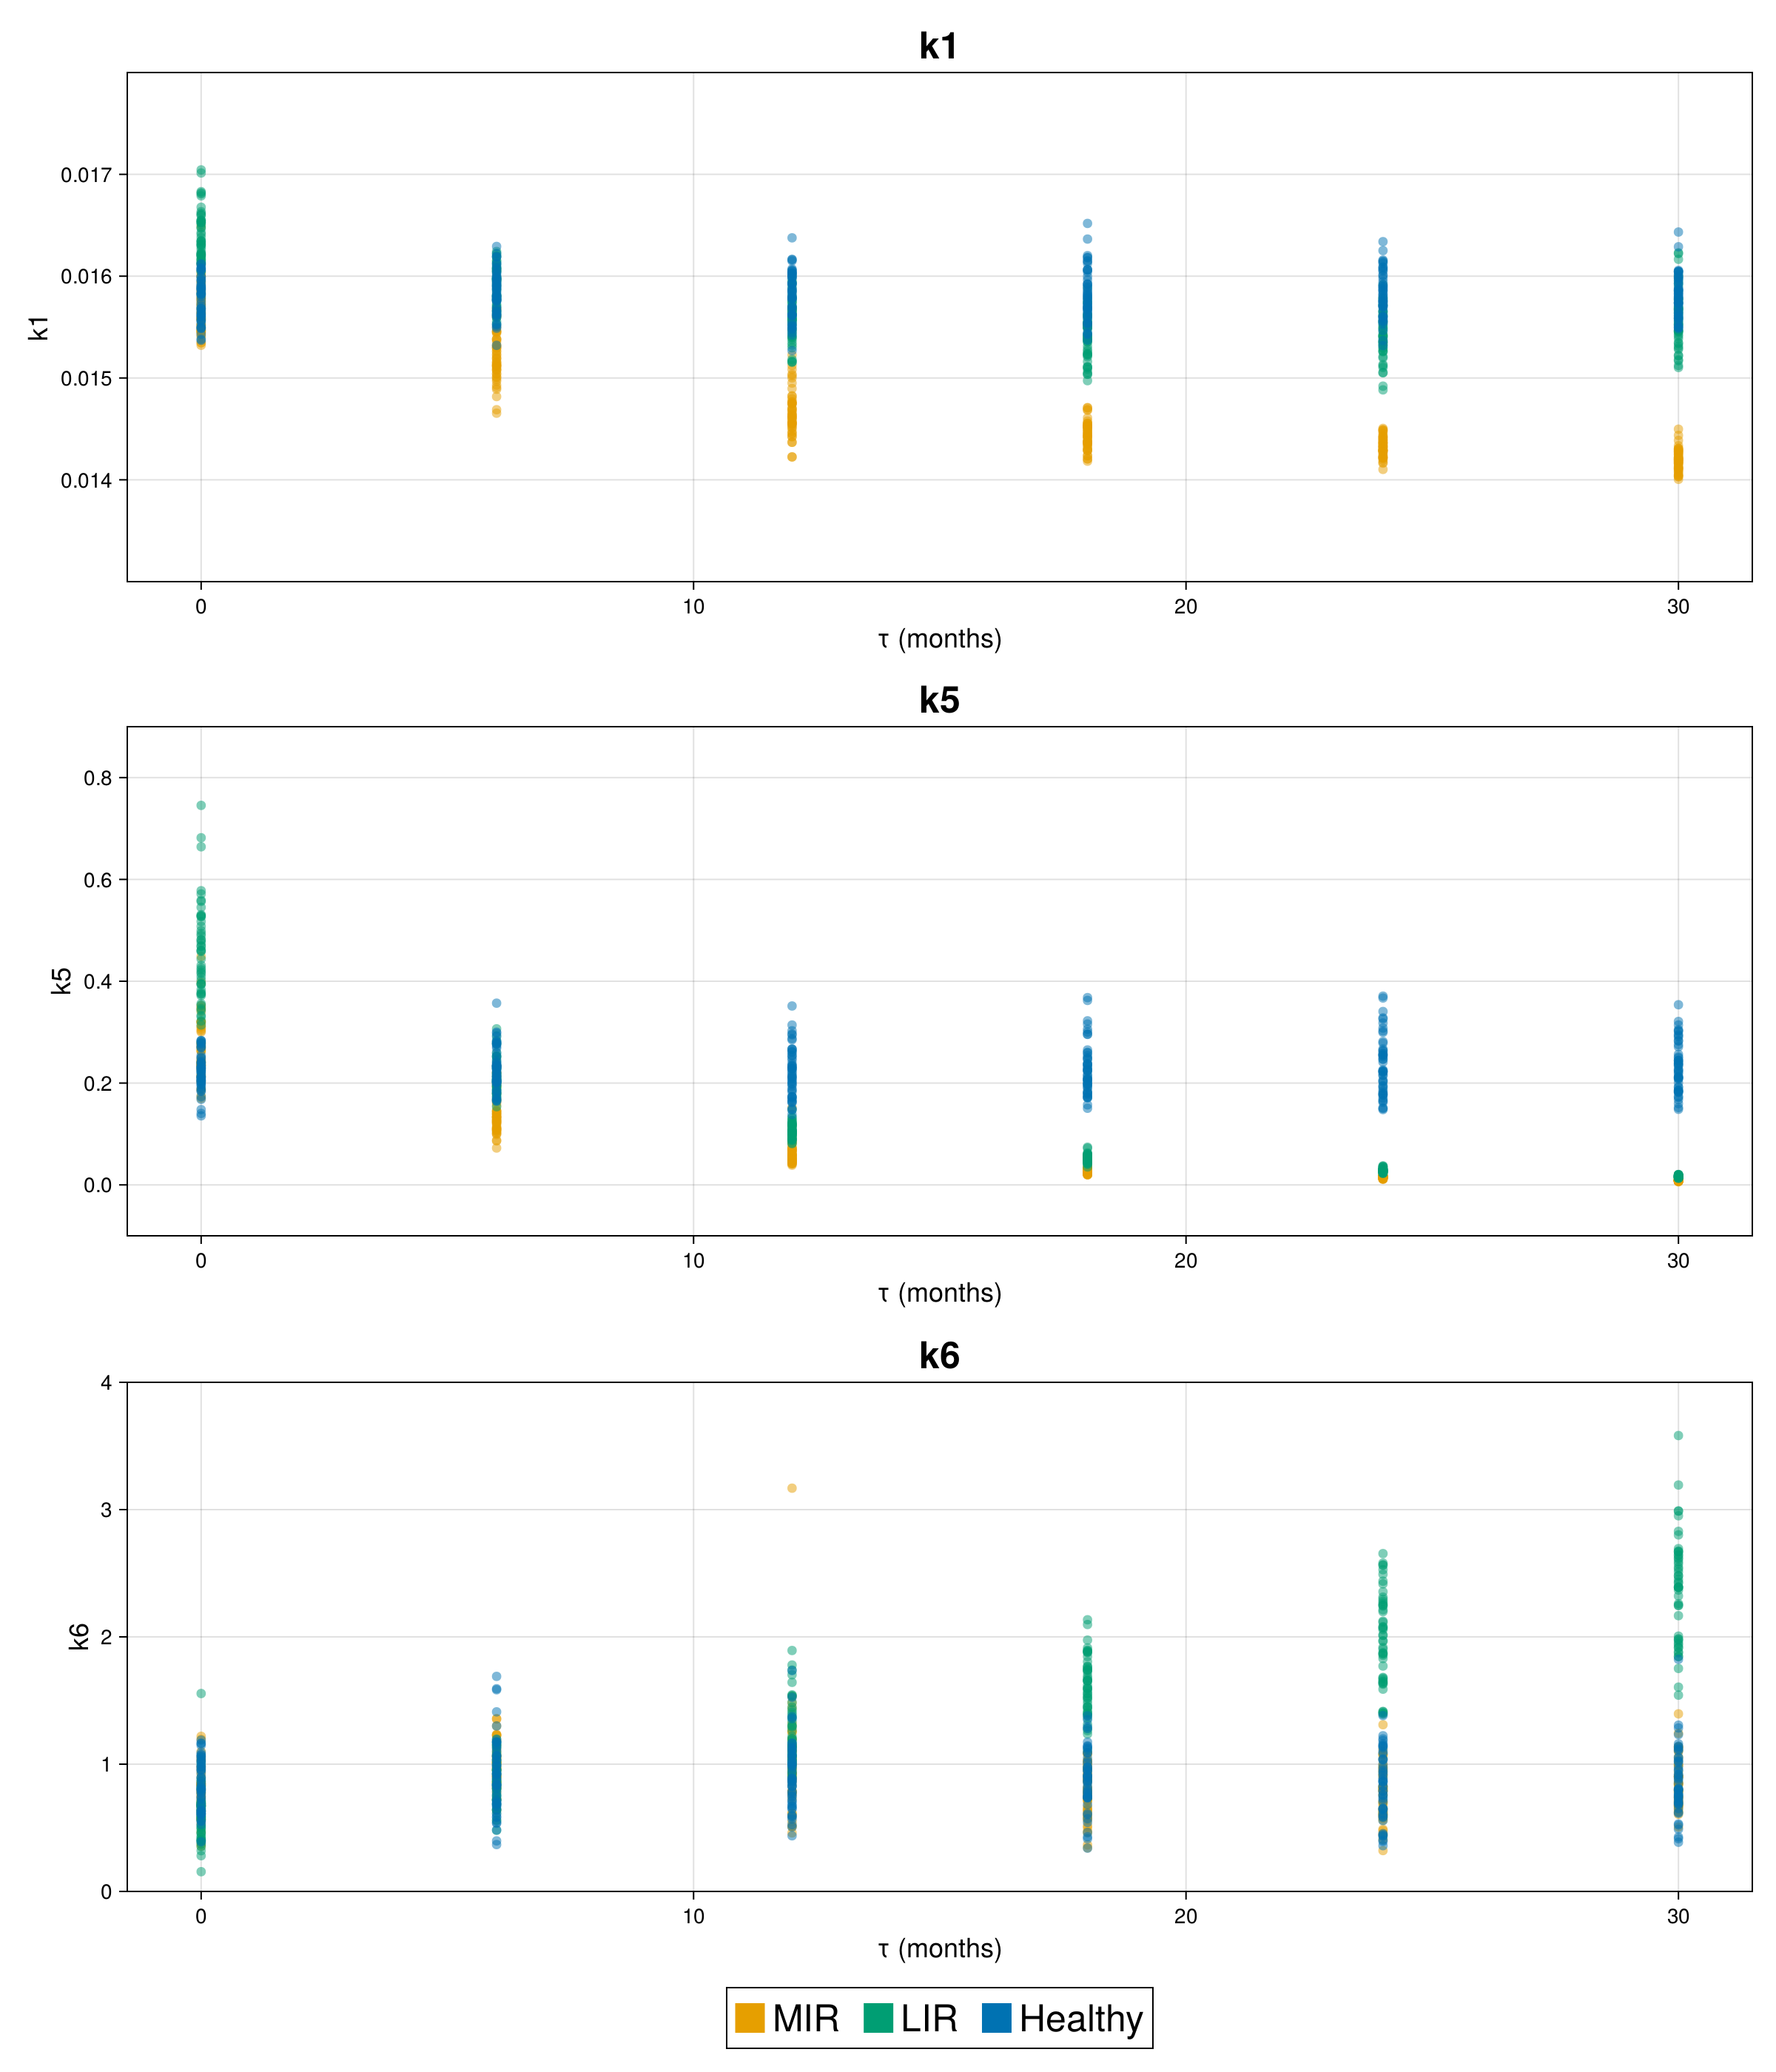

CairoMakie.Screen{IMAGE}


In [5]:
using CairoMakie

colours = Makie.wong_colors()
group_colours = Dict("Healthy" => colours[1], "MIR" => colours[2], "LIR" => colours[3])

# Convert state column to group labels
group_labels = Dict(2 => "Healthy", 1 => "MIR", 0 => "LIR")
training_set.Group = [group_labels[s] for s in training_set.state]

# Create a single figure with a 2x2 layout
fig = Figure(size=(1200, 1400))

# Function to plot a parameter in a specific axis
function plot_param!(ax, data::DataFrame, param::String)
    ax.title = param
    ax.xlabel = "τ (months)"
    ax.ylabel = param
    ax.titlefont = :bold


    for group in keys(group_colours)
        subset_data = filter(row -> row.Group == group, data)

        # Plot each patient separately to maintain time progression
        for patient in unique(subset_data.Patient_ID)
            patient_data = filter(row -> row.Patient_ID == patient, subset_data)
            scatter!(ax, patient_data.Long_time_points, patient_data[!, param], 
                   color=group_colours[group], linewidth=1.5, alpha=0.5)
        end
    end
end

# Create axes for parameters
ax1 = Axis(fig[1, 1], xlabelsize=18, ylabelsize=18, 
xticklabelsize=14, yticklabelsize=14, titlesize = 25)
ylims!(ax1, 0.013, 0.018)
ax2 = Axis(fig[2, 1], xlabelsize=18, ylabelsize=18, 
xticklabelsize=14, yticklabelsize=14, titlesize = 25)
ylims!(ax2, -0.1, 0.9)
ax3 = Axis(fig[3, 1], xlabelsize=18, ylabelsize=18, 
xticklabelsize=14, yticklabelsize=14, titlesize = 25)
ylims!(ax3, 0,4)

# Plot each parameter
plot_param!(ax1, training_set, "k1")
plot_param!(ax2, training_set, "k5")
plot_param!(ax3, training_set, "k6")

Legend(fig[end+1, 1], [PolyElement(color=group_colours[g]) for g in keys(group_colours)], 
       collect(keys(group_colours)), orientation = :horizontal, halign=:center, labelsize = 25)

# Display the figure
display(fig)

# save the figure
# save("EDES_parameters_MIRLIR.png", fig)



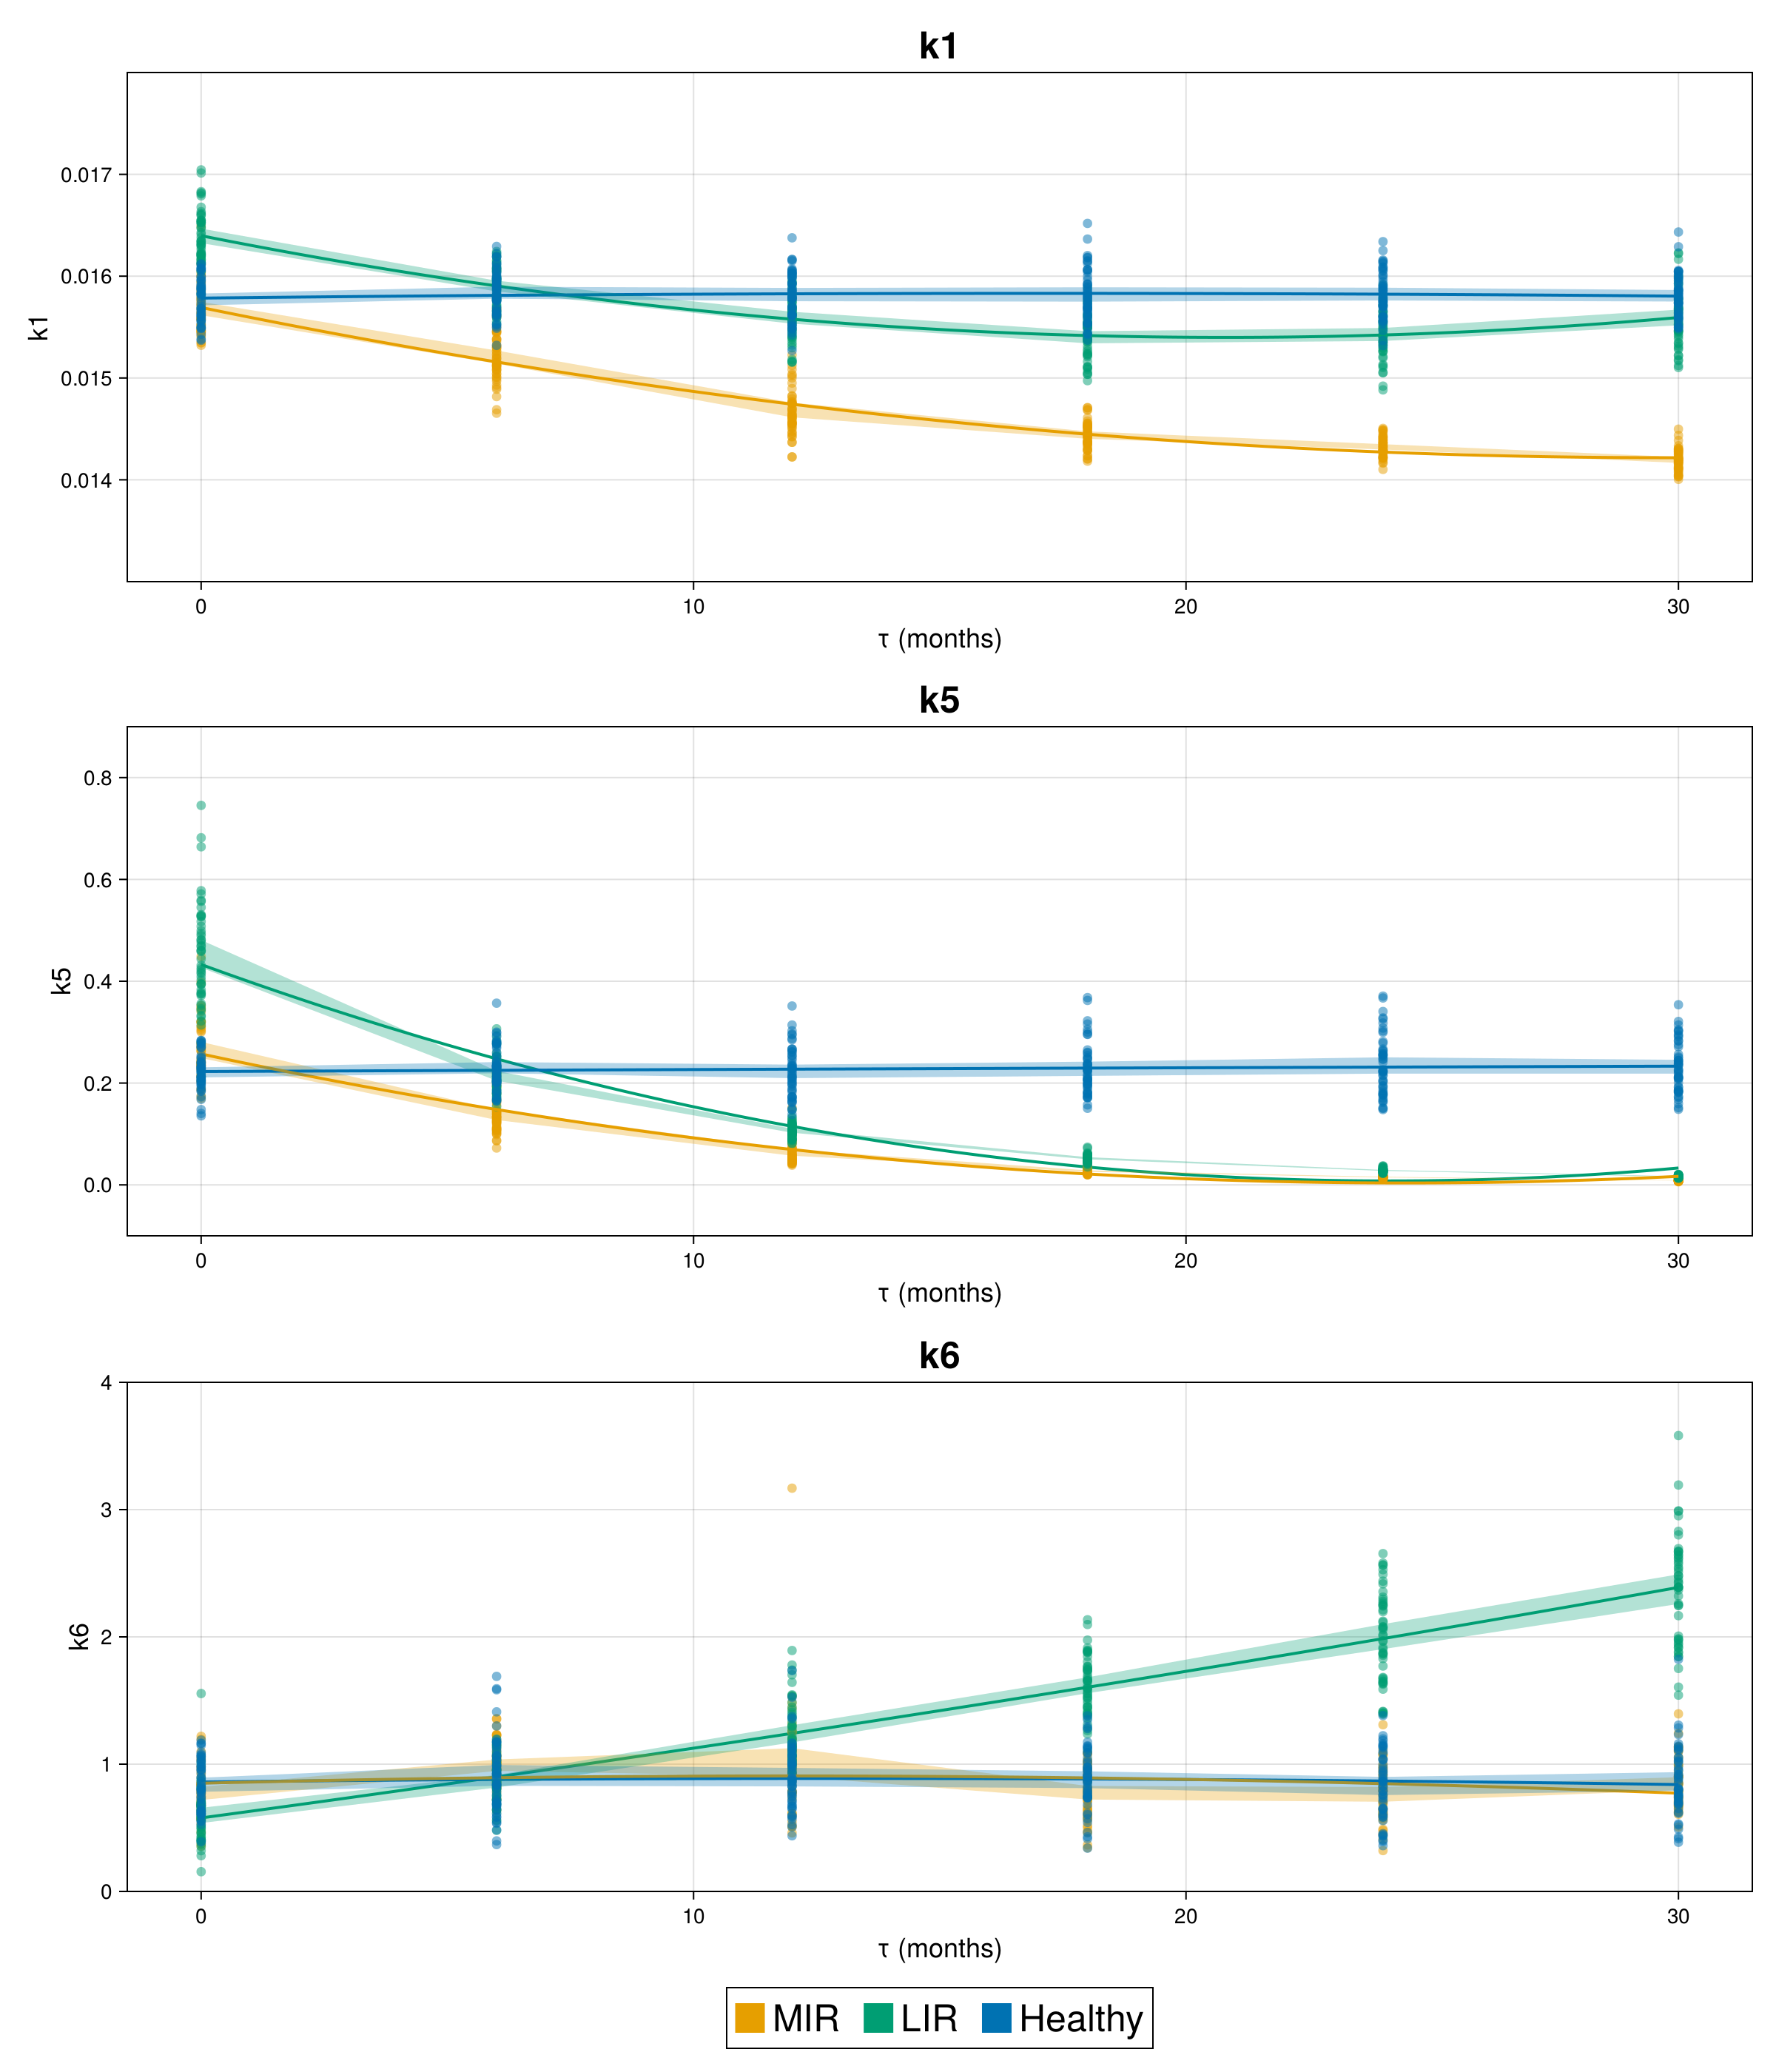

CairoMakie.Screen{IMAGE}


In [32]:
using CairoMakie
using Statistics

colours = Makie.wong_colors()
group_colours = Dict("Healthy" => colours[1], "MIR" => colours[2], "LIR" => colours[3])
LCTA_colours = [colours[3], colours[1], colours[2]]
# Convert state column to group labels
group_labels = Dict(2 => "Healthy", 1 => "MIR", 0 => "LIR")
training_set.Group = [group_labels[s] for s in training_set.state]

# Create a single figure with a 2x2 layout
fig = Figure(size=(1200, 1400))

# Function to plot a parameter in a specific axis with 95% CI bands
function plot_param_with_CI!(ax, data::DataFrame, param_matrix::AbstractMatrix, param::String,time_points_LCTA = 0:0.1:30)
    ax.title = param
    ax.xlabel = "τ (months)"
    ax.ylabel = param
    ax.titlefont = :bold

    intercepts = param_matrix[1, :]
    linear_coeffs = param_matrix[2, :]
    quadratic_coeffs = param_matrix[3, :]
    random_variances = param_matrix[4, :]  # Assuming row 4 contains sigma2.Random
    residual_variances = param_matrix[5, :]



    for (i,group) in enumerate(keys(group_colours))
        subset_data = filter(row -> row.Group == group, data)

        mean_traj = intercepts[i] .+ linear_coeffs[i] .* time_points_LCTA .+ quadratic_coeffs[i] .* (time_points_LCTA .^ 2)
        # Calculate mean and 95% CI for each time point
        time_points = unique(subset_data.Long_time_points)
        means = [mean(filter(row -> row.Long_time_points == tp, subset_data)[!, param]) for tp in time_points]
        stds = [std(filter(row -> row.Long_time_points == tp, subset_data)[!, param]) for tp in time_points]
        cis = [1.96 * std(filter(row -> row.Long_time_points == tp, subset_data)[!, param]) / sqrt(nrow(filter(row -> row.Long_time_points == tp, subset_data))) for tp in time_points]
        # Plot mean line

        lines!(ax, time_points_LCTA, mean_traj, color=LCTA_colours[i], linewidth=2)

        # Plot 95% CI bands
        band!(ax, time_points, means .- cis, means .+ cis, color=(group_colours[group],0.3))

        for patient in unique(subset_data.Patient_ID)
            patient_data = filter(row -> row.Patient_ID == patient, subset_data)
            scatter!(ax, patient_data.Long_time_points, patient_data[!, param], 
                   color=group_colours[group], linewidth=1.5, alpha=0.5)
        end
    end
end

# Create axes for parameters
ax1 = Axis(fig[1, 1], xlabelsize=18, ylabelsize=18, 
xticklabelsize=14, yticklabelsize=14, titlesize = 25)
ylims!(ax1, 0.013, 0.018)
ax2 = Axis(fig[2, 1], xlabelsize=18, ylabelsize=18, 
xticklabelsize=14, yticklabelsize=14, titlesize = 25)
ylims!(ax2, -0.1, 0.9)
ax3 = Axis(fig[3, 1], xlabelsize=18, ylabelsize=18, 
xticklabelsize=14, yticklabelsize=14, titlesize = 25)
ylims!(ax3, 0,4)

k1_matrix = flexmix_parameters["params"][1]
k5_matrix = flexmix_parameters["params"][2] 
k6_matrix = flexmix_parameters["params"][3] 

# Plot each parameter with 95% CI bands
plot_param_with_CI!(ax1, training_set, k1_matrix, "k1")
plot_param_with_CI!(ax2, training_set, k5_matrix,  "k5")
plot_param_with_CI!(ax3, training_set, k6_matrix,  "k6")

Legend(fig[end+1, 1], [PolyElement(color=group_colours[g]) for g in keys(group_colours)], 
       collect(keys(group_colours)), orientation = :horizontal, halign=:center, labelsize = 25)

# Display the figure
display(fig)

# save the figure
save("parameters_and_LCTA_MIRLIR.png", fig)



In [24]:

intercepts = k1_matrix[1, :]
linear_coeffs = k1_matrix[2, :]
quadratic_coeffs = k1_matrix[3, :]
random_variances = k1_matrix[4, :]  # Assuming row 4 contains sigma2.Random
residual_variances = k1_matrix[5, :]

3-element Vector{Float64}:
 4.021784706404181e-8
 3.4510033641729244e-8
 3.327681770615218e-8

In [25]:
k1_matrix

5×3 Matrix{Float64}:
  0.0163973    0.0157844    0.0156924
 -9.60103e-5   5.46659e-6  -9.91066e-5
  2.30763e-6  -1.60363e-7   1.66459e-6
  1.26674e-8   1.49934e-8   3.31048e-9
  4.02178e-8   3.451e-8     3.32768e-8